### Import Statements

In [11]:
import numpy as np
import scipy as sp
import json
import csv
from sklearn.feature_extraction import text
import matplotlib.pyplot as plt

## Feature Visualization

['2147476221', '804', '39', '20.76', '75000', '4.055226667', '1']


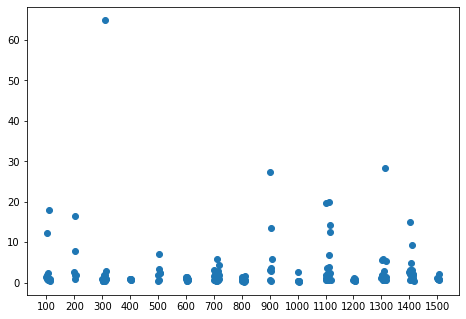

In [12]:
class Visualize(object):
    def __init__(self):
        csv_file = open('KickStarterData_nb.csv', encoding="utf-8")
        csv_reader = csv.reader(csv_file, delimiter=',')

        #print((list(csv_reader)[0]))
        self.csv_list = list(csv_reader)
        #self.data_array = np.array(csv_list)
        #print(np.shape(self.data_array))
        #self.csv_list.pop[0]
        
        # self.data_arr = np.empty((len(list(csv_reader)), 15), dtype=object)
        # counter = 0
        # for row in csv_reader:
        #     temp_arr = np.array(row)
        #     self.data_arr[counter] = temp_arr
        #     counter += 1
        #     print("in for loop")
    
    def average(self):
        #category code per percent of goal reached per period of time (normalized)
        #print(self.csv_file[0])
        #print(type(self.csv_file[0]))
        
        # rows = np.shape(self.data_arr)[0]
        # print(self.data_arr[0:2])
        
        x = []
        x_dict = {}
        y = []
        counter = 0
        print(self.csv_list[1])
        for rowlist in self.csv_list:
            if counter == 0:
                counter += 1
                continue
            if (float(rowlist[1]) in x_dict):
                x_dict[float(rowlist[1])].append(float(rowlist[5]))
            else:
                x_dict[float(rowlist[1])] = [float(rowlist[5])]
        for key in x_dict.keys():
            x.append(key)
            y.append(sum(x_dict[key])/len(x_dict[key]))
        


        
        figure = plt.figure()
        axis = figure.add_axes([0,0,1,1])
        axis.xaxis.set_ticks(np.arange(100, 1600, 100))
        axis.scatter(x, y)
        plt.show() 

    def count(self):
        x_dict = {}
        counter = 0
        print(self.csv_list[1])
        for rowlist in self.csv_list:
            if counter == 0:
                counter += 1
                continue
            if ((float(rowlist[1])//100)*100 in x_dict):
                x_dict[(float(rowlist[1])//100)*100] += 1
            else:
                x_dict[(float(rowlist[1])//100)*100] = 1
        x = x_dict.keys()
        y = x_dict.values()
        
        figure = plt.figure()
        axis = figure.add_axes([0,0,1,1])
        axis.xaxis.set_ticks(np.arange(100, 1600, 100))
        axis.bar(x, y)
        plt.show() 

vis = Visualize()
vis.average()
        
        
        

## Classes

In [13]:
# Dataset constants ==============================
N = 331675   # Number of points
D = 5   # Number of (useful) features
C = 172    # Number of unique categories
mC = 1508    # Largest label coding (plus one for array creation purposes)

class NaiveBayes(object):
    
    def __init__(self):
        # Load test file
        csv_file = open('KickStarterData_nb.csv', encoding="utf-8")
        csv_reader = csv.reader(csv_file, delimiter=',')
        
        data_arr = np.empty((N, D + 1))    # D + 1 since need to account for the labels
        counter = -2    # For skipping the row of feature names 
        for row in csv_reader:
            counter += 1
            if (counter == -1):
                continue
                            
            temp_arr = np.array(row)
            data_arr[counter] = temp_arr[1:]    # Ignores the ID vaules
        
        # Splits the data between data points and labels
        self.x = data_arr[:, 0:D]
        self.y = data_arr[:, D]
        
        # Set all other instance variables to None
        self.priors = None
        self.likelihoods_cont_0 = None
        self.likelihoods_cont_1 = None
        self.likelihood_cat_0 = None
        self.likelihood_cat_1 = None
        
    def find_priors(self, y_train):
        """
        ARGS:
            y_train: (N,) numpy array, labels for the points in the training set
        SETS:
            self.priors: (2,) numpy array, the probabilities of having a label of 0 or 1, P(y)
        """
        # Get total number of labels
        N_train = np.shape(y_train)[0]
        
        # Get the number of each label
        num_1 = y_train.sum()
        num_0 = N_train - num_1
        
        # Calculate each prior
        priors = np.array([num_0, num_1])
        priors = priors / N_train
        
        self.priors = priors

    def find_likelihoods_cont(self, x_train, y_train):
        """
        Finds the mean and variance of each continuous feature (so all features minus category) to be
        able to use a Guassian estimation.
        
        ARGS:
            x_train: (N, D) numpy array, data set for the model to be trained on
            y_train: (N,) numpy array, labels for x_train
        SETS:
            self.likelihoods_cont_0: (D, 2) numpy array, the means ([:, 0]) and the variance
                                     ([:, 1]) of each of the D continuous features for y = 0, P(x|y = 0)
            self.likelihoods_cont_1: (D, 2) numpy array, the means ([:, 0]) and the variance
                                     ([:, 1]) of each of the D continuous features for y = 1, P(x|y = 1)
        """
        # Transpose the labels to be vertical
        y_train_vert = np.array([y_train]).T
        
        # Get the data points for each label
        x_train_1 = x_train * y_train_vert
        x_train_1 = x_train_1[~np.all(x_train == 0, axis=1)]
        x_train_0 = x_train * (1 - y_train_vert)
        x_train_0 = x_train_0[~np.all(x_train == 0, axis=1)]
        
        # Get the means and variances for each subset of the training set
        avg_0 = np.average(x_train_0, axis=0)
        var_0 = np.var(x_train_0, axis=0)
        avg_1 = np.average(x_train_1, axis=0)
        var_1 = np.var(x_train_1, axis=0)
        
        # Stack the means and variances to fit the (D, 2) shape
        hyper_params_0 = np.column_stack((avg_0, var_0))
        hyper_params_1 = np.column_stack((avg_1, var_1))
        
        self.likelihoods_cont_0 = hyper_params_0
        self.likelihoods_cont_1 = hyper_params_1
        
    def find_likelihoods_cat(self, x_train, y_train):
        """
        Finds the likelihood of each category. Uses Laplace Smoothing to avoid zeros, where the added value
        is 1/N, where N is the number of unique values. (Add-1 Smoothing is Laplace Smoothing when the added
        value is 1.)
        Wiki Article on Laplace Smooting: https://en.wikipedia.org/wiki/Additive_smoothing
        
        ARGS:
            x_train: (N, D) numpy array, data set for the model to be trained on
            y_train: (N,) numpy array, labels for x_train
        SETS:
            self.likelihoods_cat_0: (mC,) numpy array, the likelihood for each category for y = 0, P(x|y = 0)
            self.likelihoods_cat_1: (mC,) numpy array, the likelihood for each category for y = 1, P(x|y = 1)
        """
        # Get the number of each label
        num_1 = y_train.sum()
        num_0 = np.shape(y_train)[0] - num_1
        
        # Transpose the labels to be vertical
        y_train_vert = np.array([y_train]).T
        
        # Get the data points for each label
        x_train_1 = x_train * y_train_vert
        x_train_1 = x_train_1[~np.all(x_train == 0, axis=1)]
        x_train_0 = x_train * (1 - y_train_vert)
        x_train_0 = x_train_0[~np.all(x_train == 0, axis=1)]
        
        # Isolate the category IDs
        x_train_0 = x_train_0[:, 0]
        x_train_1 = x_train_1[:, 0]
        
        # Instantiate the likelihood arrays
        likelihood_cat_0 = np.zeros((mC,))
        likelihood_cat_1 = np.zeros((mC,))
        
        # Count the number of each category
        for val in x_train_0.astype(int):
            likelihood_cat_0[val] += 1
        for val in x_train_1.astype(int):
            likelihood_cat_1[val] += 1
            
        # Calculate smoothing value
        smoothing_alpha = 1 / C
        
        # Calculate likelihoods
        # Note that the sum will yield >1, but only because there are many unused values
        # If summing only the used values, will yield 1
        likelihood_cat_0 = (likelihood_cat_0 + smoothing_alpha) / (num_0 + 1)
        likelihood_cat_1 = (likelihood_cat_1 + smoothing_alpha) / (num_1 + 1)
        
        self.likelihood_cat_0 = likelihood_cat_0
        self.likelihood_cat_1 = likelihood_cat_1
        
    def train(self, x_train, y_train):
        """
        ARGS:
            x_train: (N, D) numpy array, data set for the model to be trained on
                Note: Feature 1 (Category) is ordinal and should be treated as such
                      All other features are continuous and should be treated as such (Guassian Distribution)
            y_train: (N,) numpy array, labels for x_train
        SET:
            All the instance variables (implicitly)
        NOTE:
            Since classification is based on relative values, the normalization constant
            (the denominator, P(X)) is not needed and does not need to be calculated
        """
        print("    Starting to find the priors...")
        self.find_priors(y_train)
        print("    Completed finding the priors...\n")
        
        print("    Starting to find the likelihood of the categories...")
        self.find_likelihoods_cat(x_train, y_train)
        print("    Completed finding the likelihood of the categories...\n")
        
        print("    Starting to find the likelihoods of the rest of the features...")
        self.find_likelihoods_cont(x_train, y_train)
        print("    Completed finding the likelihoods of the rest of the features...")
        
    def test(self, x_test):
        """
        ARGS:
            x_test: (N, D) numpy array, data set for the model to be tested on
                Note: Feature 1 (Category) is ordinal and should be treated as such
                      All other features are continuous and should be treated as such (Guassian Distribution)
        RETURNS:
            y_pred: (N,) numpy array, predicted labels
        NOTE:
            Since classification is based on relative values, the normalization constant
            (the denominator, P(X)) is not needed and does not need to be calculated
        """
        # Get number of data points in the test set
        N_test, D_test = np.shape(x_test)
        
        # Probabilities of each label for each data point
        prob = np.zeros((N_test, 2))
        
        # Start with the priors, P(y)
        prob = prob + self.priors
        
        # Multiply the likelihood of the categories, P(x = category|y)
        likelihood_cat_0 = self.likelihood_cat_0[x_test[:, 0].astype(int)]
        likelihood_cat_1 = self.likelihood_cat_1[x_test[:, 0].astype(int)]
        likelihood_cat = np.column_stack((likelihood_cat_0, likelihood_cat_1))
        prob = prob * likelihood_cat
        
        # Multiply the probabilities from the continuous features, P(x = everything else|y)
        for i in range(1, D_test):
            curr_features = x_test[:, i]
            
            mean_0 = self.likelihoods_cont_0[i - 1, 0]
            std_dev_0 = np.sqrt(self.likelihoods_cont_0[i - 1, 1])
            mean_1 = self.likelihoods_cont_1[i - 1, 0]
            std_dev_1 = np.sqrt(self.likelihoods_cont_1[i - 1, 1])
            
            curr_features_prob_0 = sp.stats.norm.pdf(curr_features, mean_0, std_dev_0)
            curr_features_prob_1 = sp.stats.norm.pdf(curr_features, mean_1, std_dev_1)
            
            curr_features_prob = np.column_stack((curr_features_prob_0, curr_features_prob_1))
            
            prob = prob * curr_features_prob
        
        # Find predicted labels
        y_pred = np.argmax(prob, axis=1)
        
        return y_pred
    
    def calc_error(self, y_test, y_pred):
        """
        ARGS:
            y_test: (N,) numpy array, true labels of the test set
            y_pred: (N,) numpy array, predicted labels of the test set
        RETURNS:
            error: float, error rate of this Naive Bayes model
        """
        # Get number of data points that were tested
        N_tested = np.shape(y_test)[0]
        
        # Get the number of wrong predictions
        num_wrong = np.bitwise_xor(y_test.astype(int), y_pred.astype(int)).sum()
        
        error = num_wrong / N_tested
        
        return error
        

In [25]:
class Cleaning(object):
    #class to handle cleaning data (standardizing features, dimensionality reduction, etc.)
    
    def __init__(self):
        self.U = None
        self.V = None
        self.S = None

    #PCA for dimensionality reduction of the dataset
    def pca(self, X, var = False, k=2):
        """
        ARGS:
            X: (N X D) data set as a numpy array, uncentered
            var: whether to use retained variance or number of features as the basis of reduction
            k: if var=FALSE, k is the number of features to be kept. if var=TRUE, k is the retained variance as a decimal

        RETURNS:
            new_data: dataset (as a numpy array) obtained by applying PCA on the original dataset

        SETS:
            self.U: (N, min(N,D))
            self.V: (min(N,D), D)
            self.S: (min(N,D), ) 
        """

        #center the data set
        centeredData = X - np.mean(X, axis=0)
        self.U, self.S, self.V = np.linalg.svd(centeredData, full_matrices = False)

        #if var== False, do PCA based on the specified number of features
        if (var == False):
            #if k not entered correctly (less than one feature entered), assume default number of features
            if (k < 1):
                k = 2
            self.U = self.U[:,0:k]
            self.S = self.S[0:k]
            self.V = self.V[0:k,:]
            new_data = np.matmul(centeredData, (self.V).T)
        
        #if var==True, do PCA based on the specified number of features
        else:
            #if k not entered correctly (greater than 100%), assume default variance
            if (k >= 1):
                k = .99
            new_data = np.matmul(centeredData, (self.V).T)
            origVar = np.sum(np.square(self.S))
            ssquared = np.square(self.S)
            for i in range(np.shape(centeredData)[1]):
                var = np.sum(ssquared[0:i])/origVar
                if (var >= k):
                    self.S = self.S[0:i]
                    self.U = self.U[:,0:i]
                    self.V = self.V[0:i,:]
                    new_data= np.matmul(centeredData, (self.V).T)
        return new_data

    
    def visualize_pca(self, X):
        plt.title("Kickstarter dataset with Dimensionality Reduction")
        row = 0
        col = 1
        job_id = np.array([e for e in cat_column])
        print(X)
        plt.scatter(X[:, 1], X[:, 2], label = 'categories', color = 'blue')

        plt.legend()
        plt.show()





## Training and Testing the Model

Starting to create the model...
Completed creating the model...

Starting to run PCA on the data...
[[ 8.04000000e+02 -3.34899985e+04  5.60309642e-01]
 [ 1.10000000e+03  3.15100015e+04 -2.39974134e+00]
 [ 1.20200000e+03  4.01169815e+04 -3.51803518e+00]
 ...
 [ 1.08000000e+02  4.12788015e+04 -2.36293502e+00]
 [ 1.11800000e+03  2.65100015e+04 -3.51029726e+00]
 [ 2.00000000e+02 -6.48999846e+03 -3.49938986e+00]]


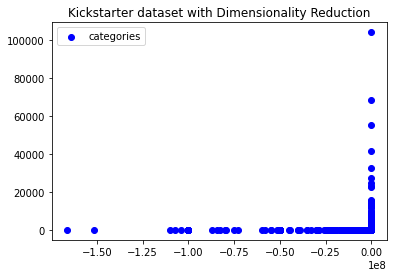

Completed running PCA on the data...
Starting to train the model...
    Starting to find the priors...
    Completed finding the priors...

    Starting to find the likelihood of the categories...
    Completed finding the likelihood of the categories...

    Starting to find the likelihoods of the rest of the features...
    Completed finding the likelihoods of the rest of the features...
Completed training the model...

Starting to test the model...
Completed testing the model...

The model had an accuracy of 0.5916.


In [26]:
print("Starting to create the model...")
nb = NaiveBayes()
print("Completed creating the model...\n")

print("Starting to run PCA on the data...")
cat_column = np.array([nb.x[:, 0]]).T
clean = Cleaning()
cleaned_x = clean.pca(nb.x[:, 1:])    # Don't run the categories through PCA since it is ordinal data
cleaned_x = np.hstack((cat_column, cleaned_x))
clean.visualize_pca(cleaned_x)
print("Completed running PCA on the data...")

# Test on 20% of the dataset
test_amount = N // 5
x_test = cleaned_x[0:test_amount, :]
y_test = nb.y[0:test_amount]
x_train = cleaned_x[test_amount:, :]
y_train = nb.y[test_amount:]

# Train the model
print("Starting to train the model...")
nb.train(x_train, y_train)
print("Completed training the model...\n")

# Test the model
print("Starting to test the model...")
y_pred = nb.test(x_test)
print("Completed testing the model...\n")

# Find the error and accuracy
error = nb.calc_error(y_test, y_pred)
accuracy = 1 - error
print("The model had an accuracy of %.4f." % accuracy)
